### This chapter will cover:

1. Getting a conceptual understanding of multilayer neural network

2. Implementing the fundamental backpropagation algorithm for neural network training from scatch

3. Training a basic multilayer neural network for image classification

# Classifying handwritten digits

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 samples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 samples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)

In this section, we will only be working with a subset of MNIST, thus, we only need to download the training set images and training set labels. After downloading the files, I recommend unzipping the files using the Unix/Linux gzip tool from the terminal for efficiency, e.g., using the command 

    gzip *ubyte.gz -d
 
in your local MNIST download directory, or, using your favorite unzipping tool if you are working with a machine running on Microsoft Windows. The images are stored in byte form, and using the following function, we will read them into NumPy arrays that we will use to train our MLP.


In [8]:
import os
import struct
import numpy as np

def load_mnist(path, kind = 'train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        # Unpack the string (presumably packed by pack(fmt, ...)) 
        # according to the given format. 
        # The result is a tuple even if it contains exactly one item. 
        # The string must contain exactly the amount of data required 
        # by the format (len(string) must equal calcsize(fmt)).
        
        # `fmt` parameter value '>II'
        # '>' big-endian, a sequence of bytes is stored
        # 'I' unsigned integer, 4 bytes, 'II' 8 bytes
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype = np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        # `fmt` parameter value '>IIII'
        # '>' big-endian, a sequence of bytes is stored
        # 'I' unsigned integer, 4 bytes, 'IIII' 16 bytes
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels),784)
        # normalized the pixels values in MNST to the range -1 to 1
        # (originally 0 to 255)
        # more stable gradient-based optimization
        # working with image pixels, centering them at 0 and rescaling them to
        # a [-1,1] range is also common and usually works well in practice
        images = ( ( images / 255. ) - .5 ) * 2
    
    return images, labels
        

In [2]:
!ls

 aclImdb
 aclImdb_v1.tar.gz
'Chapter 10 Predicting Continuous Target Variables with Regression Analysis.ipynb'
'Chapter 12 Implementing a Multilayer Artificial Neural Network from Scratch.ipynb'
'Chapter 2 Trainning Simple Machine Learning Algorithms for Classification.ipynb'
'Chapter 3 A Tour of Machine Learning Classifiers Using scikit-learn.ipynb'
'Chapter 4 Building Good Training Sets - Data Preprocessing.ipynb'
'Chapter 5 Compressing Data via Dimensionality Reduction.ipynb'
'Chapter 6 Learning Best Practices for Model Evaluation and Hyperparameter Tuning.ipynb'
'Chapter 7 Combining Different Models for Ensemble Learning.ipynb'
'Chapter 8 Apply Machine Learning to Sentiment Analysis.ipynb'
 movie_data.csv
 t10k-images-idx3-ubyte
 t10k-labels-idx1-ubyte
 train-images-idx3-ubyte
 train-labels-idx1-ubyte


In [5]:
# unzips mnist

import sys
import gzip
import shutil

if (sys.version_info > (3,0)):
    writemode = 'wb'
else:
    writemode = 'w'
    
zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]

for z in zipped_mnist:
    with gzip.GzipFile(z, mode = 'rb') as decompressed, open(z[:,-3],writemode) as outfile:
        outfile.write(decompressed.read())

In [6]:
!ls

 aclImdb
 aclImdb_v1.tar.gz
'Chapter 10 Predicting Continuous Target Variables with Regression Analysis.ipynb'
'Chapter 12 Implementing a Multilayer Artificial Neural Network from Scratch.ipynb'
'Chapter 2 Trainning Simple Machine Learning Algorithms for Classification.ipynb'
'Chapter 3 A Tour of Machine Learning Classifiers Using scikit-learn.ipynb'
'Chapter 4 Building Good Training Sets - Data Preprocessing.ipynb'
'Chapter 5 Compressing Data via Dimensionality Reduction.ipynb'
'Chapter 6 Learning Best Practices for Model Evaluation and Hyperparameter Tuning.ipynb'
'Chapter 7 Combining Different Models for Ensemble Learning.ipynb'
'Chapter 8 Apply Machine Learning to Sentiment Analysis.ipynb'
 movie_data.csv
 t10k-images-idx3-ubyte
 t10k-labels-idx1-ubyte
 train-images-idx3-ubyte
 train-labels-idx1-ubyte


In [10]:
X_train, y_train = load_mnist('', kind = 'train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [11]:
X_test, y_test = load_mnist('', kind = 't10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


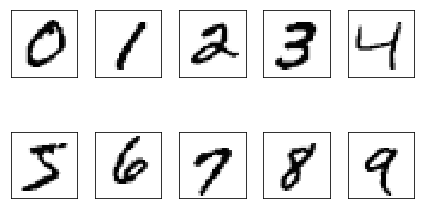

In [13]:
# Visualize the first digit of each class:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten() # 2d array to 1d array

for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

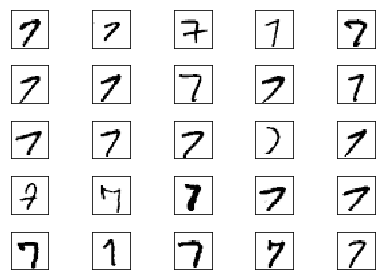

In [17]:
#visualize 25 different versions of "7"

fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()

for i in range(25):
    img = X_train[y_train == 7][i].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

In [18]:
# save multidimensional arrays to disk

import numpy as np

# `savez` optimized for storing NumPy arrays
# `savez_compressed` compresses the output file down to substantially smaller file sizes
np.savez_compressed('mnist_scaled.npz',
                    X_train = X_train,
                    y_train = y_train,
                    X_test = X_test, 
                    y_test = y_test)

In [19]:
# load the preprocessed MNIST image arrays

mnist = np.load('mnist_scaled.npz')
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [21]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train', 'X_test', 'y_test']]

del mnist

X_train.shape

(60000, 784)

## Implementing a multi-layer perceptron

In [26]:
import numpy as np
import sys

class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier
    
    Parameters
    ------------------------
    
    n_hidden: int (default: 30)
        Number of hidden units
    
    l2 : float (default: 0.)
        Lambda value for L2-regularization
        No regularization if l2 = 0 (default)
    
    epochs : int (default: 100)
        Number of passes over the training set
    
    eta: float (default: True)
        Learning rate
        
    shuffle : bool (default: True)
        Shuffles training data ever epoch if True to prevent circles
        
    minibatch_size : int (default: 1)
        Number of training samples per minibatch
    
    seed : int (default: None)
        Random seed for initializing weights and shuffling
        
    Attributes
    -----------------------
    
    eval_ : dict
        Dictionary collecting the cost, training accuracy
        and validation accuracy for each epoch during training
    
    """
    
    def __init__(self, n_hidden = 30, l2 = 0., epochs = 100,
                 eta = 0.001, shuffle = True, minibatch_size = 1,
                 seed = None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ------------------
        y: array, shape = [n_samples]
            Target values
        
        Returns
        -------------------
        onehot: array, shape = (n_samples, n_labels)
        
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val,idx] = 1.
        return onehot.T
    
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        # `np.clip` restricts z to be [-250, 250]
        return 1./(1. + np.exp(-np.clip(z,-250,250)))
    
    def _forward(self, X):
        """Compute forward propagation step"""
        
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) +self.b_h
        
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        
        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_hidden]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Compute cost function
        
        Parameters
        --------------------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot ecoded class labels
            
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)
            
        Returns
        --------------------
        cost : float
            Regularized cost
        
        
        """
        
        L2_term =  self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.))
        
        term1 = -y_enc * (np.log(output + 1e-5))
        term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        cost = np.sum(term1 - term2) + L2_term
        
        return cost
    
    def predict(self, X):
        """Predict class labels
        
        Parameters
        ---------------------
        X : array, shape = [n_samples, n_features]
            Input layer with original features
            
        Returns:
        ---------------------
        y_pred : array, shape = [n_samples]
            Predicted class labels
        
        """
        
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis = 1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """Learn weights from training data.
        
        Parameters
        ------------------------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features
        y_train : array, shape = [n_samples]
            Target class labels
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training
        
        Returns:
        --------------------------
        self
        
        """
        
        n_output = np.unique(y_train).shape[0] # number of class labels
        n_features = X_train.shape[1]
        
        ###########################################
        # Weight initialization
        ###########################################
        
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc = 0.0, scale = 0.1,
                                      size = (n_features, self.n_hidden))
        
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc = 0.0, scale = 0.1,
                                        size = (self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progress formatting
        self.eval_ = {'cost' : [], 'train_acc' : [], 'valid_acc': []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            for start_idx in range(0, indices.shape[0] - self.minibatch_size+1,
                                  self.minibatch_size):
                batch_idx = indices[start_idx : start_idx + self.minibatch_size]
                
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                ########################
                # Backpropagation
                ########################
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * 
                           sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis = 0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis = 0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
            
            #####################
            # Evaluation
            #####################
            
            # Evaluate after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc = y_train_enc, output = a_out)
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% '% 
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc * 100))
            
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
    
        return self


    

In [27]:
n_epochs = 200

nn = NeuralNetMLP(n_hidden = 100,
                  l2 = 0.01,
                  epochs = n_epochs,
                  eta = 0.0005,
                  minibatch_size = 100,
                  shuffle = True,
                  seed = 1)

nn.fit(X_train = X_train[:55000],
       y_train = y_train[:55000],
       X_valid = X_train[55000:],
       y_valid = y_train[55000:])

200/200 | Cost: 5060.02 | Train/Valid Acc.: 99.28%/97.98%  

---
**Note**

In the fit method of the MLP example above,

```python

for idx in mini:
...
    # compute gradient via backpropagation
    grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                      a3=a3, z2=z2,
                                      y_enc=y_enc[:, idx],
                                      w1=self.w1,
                                      w2=self.w2)

    delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
    self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
    self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
    delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
```

`delta_w1_prev` (same applies to `delta_w2_prev`) is a memory view on `delta_w1` via  

```python
delta_w1_prev = delta_w1
```
on the last line. This could be problematic, since updating `delta_w1 = self.eta * grad1` would change `delta_w1_prev` as well when we iterate over the for loop. Note that this is not the case here, because we assign a new array to `delta_w1` in each iteration -- the gradient array times the learning rate:

```python
delta_w1 = self.eta * grad1
```

The assignment shown above leaves the `delta_w1_prev` pointing to the "old" `delta_w1` array. To illustrates this with a simple snippet, consider the following example:


In [28]:
import numpy as np

a = np.arange(5)
b = a
print('a & b', np.may_share_memory(a, b))


a = np.arange(5)
print('a & b', np.may_share_memory(a, b))

a & b True
a & b False


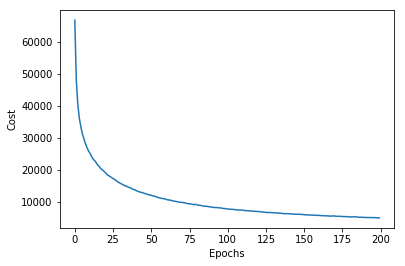

In [29]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

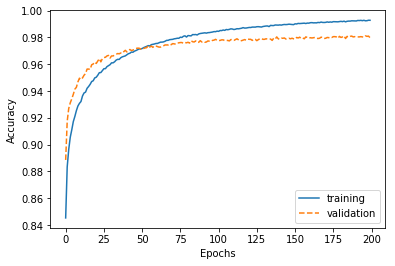

In [30]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [31]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 97.54%


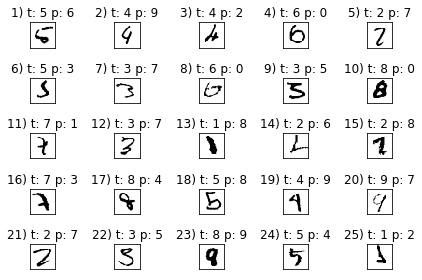

In [32]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('images/12_09.png', dpi=300)
plt.show()